# Stock Price Predictions Using LSTM

In [1]:
import pandas as pd 
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from datetime import datetime
import tensorflow as tf
from tensorflow import keras
tf.random.set_seed(42)
from sklearn.preprocessing import MinMaxScaler

In [2]:
class Data():
    def __init__(self, ticker, start=None, end=None, n_input=None, n_feats=None):
        
        self.ticker = ticker
        if start == None:
            start = '2020-01-01' # default start date
        if end == None:
            end = datetime.today().strftime('%Y-%m-%d')
        self.start = start
        self.end = end
        if n_input == None:
            n_input = 60
        if n_feats == None:
            n_feats = 1
        self.n_input = n_input
        self.n_feats = n_feats
        
        data = yf.Ticker(self.ticker)
        ts = data.history(start=self.start, end=self.end, rounding=True)
        self.ts = ts[['Close']]
        self.scaler = MinMaxScaler()
        self.ts_sc = self.scaler.fit_transform(self.ts)
        
        self.num_train = round(len(self.ts)*0.8)
        
    def get_ts(self):
        
        print(f'TICKER: {self.ticker}')
        figure = plt.figure()
        plt.plot(self.ts)
        figure.autofmt_xdate()
        plt.title(self.ticker)
        return self.ts
    
    def preprocess(self):
        # self.scaler attribute needed for model, so initialized in constructor
        
        self.train = self.ts_sc[:self.num_train]
        self.val = self.ts_sc[self.num_train:]

        return self.train, self.val
    
    def create_train_data(self):

        x_train = []
        y_train = []
        print(f'Using {self.num_train} days for training, {len(self.ts)-self.num_train} days for validating.\n')
        print('Creating training data...')

        for i in range(self.n_input, len(self.train)):
            x_train.append(self.train[i-self.n_input:i, 0])
            y_train.append(self.train[i, 0])
       
        self.x_train, self.y_train = np.array(x_train), np.array(y_train)
        print(f'-    Before reshape: {self.x_train.shape}, {self.y_train.shape}')
        self.x_train = self.x_train.reshape(self.x_train.shape[0], self.x_train.shape[1], 1) 
        # added extra dimension, x_train.shape = (len(x_train), n_input)
        print(f'-    After reshape: {self.x_train.shape}, {self.y_train.shape}')
        print('Created training data.\n')

        return self.x_train, self.y_train

    def create_val_data(self):
    
        x_val = []
        y_val = self.val[self.n_input:] # need first n_inputs to calculate n_inputs + 1
        print('Creating validation data...')
        
        for i in range(self.n_input, len(self.val)): # 1953 - end
            x_val.append(self.val[i-self.n_input:i, 0])

        x_val, y_val = np.array(x_val), np.array(y_val)
        print(f'-    Before reshape: {x_val.shape}, {y_val.shape}')
        self.x_val = x_val.reshape(x_val.shape[0], x_val.shape[1], 1)
        self.y_val = y_val.reshape(-1) 
        print(f'-    After reshape: {self.x_val.shape}, {self.y_val.shape}')
        print('Created validation data.\n')

        return self.x_val, self.y_val

TICKER: AMZN


,Close
Date,
2010-01-04 00:00:00-05:00,6.70
2010-01-05 00:00:00-05:00,6.73
2010-01-06 00:00:00-05:00,6.61
2010-01-07 00:00:00-05:00,6.50
2010-01-08 00:00:00-05:00,6.68
...,...
2019-12-24 00:00:00-05:00,89.46
2019-12-26 00:00:00-05:00,93.44
2019-12-27 00:00:00-05:00,93.49


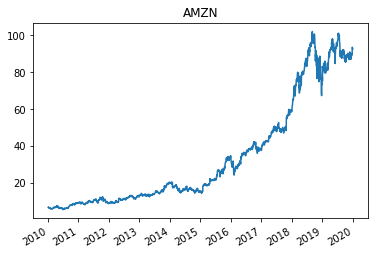

In [3]:
AMZN = Data('AMZN', start='2010-01-01', end='2020-01-01')
AMZN.get_ts()

In [4]:
# from tensorflow.python.util import deprecation
# deprecation._PRINT_DEPRECATION_WARNINGS = False

class Model(Data):
    def __init__(self, ticker, unit, start=None, end=None, n_input=None, n_feats=None):
        
        super(Model, self).__init__(ticker, start, end, n_input, n_feats)
        self.unit = unit
        self.model = None
        
    def LSTM(self):

        print("[Grabbing data...]")
        data = Data(self.ticker, self.start, self.end)
        data.preprocess()
        self.x_train, self.y_train = data.create_train_data()
        self.x_val, self.y_val = data.create_val_data()
        
        # Creating model
        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.layers.LSTM(self.unit, input_shape = (self.n_input, self.n_feats), return_sequences=True))
        self.model.add(tf.keras.layers.LSTM(self.unit, return_sequences=False))

        self.model.add(tf.keras.layers.Dense(16))
        self.model.add(tf.keras.layers.Dense(1))

        self.model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam(), metrics=['MSE'])
        print("Created and compiled LSTM model.\n")
        
        print("Training model...")
        history = self.model.fit(self.x_train, self.y_train, epochs=10, batch_size=16, verbose=1)

        return
    
    def get_model(self):
        
        if self.model==None:
            return print('Model has not yet been created.')
        return self.model.summary()
    
    def plot_preds(self):
        
        data = Data(self.ticker)
        self.train, self.val = data.preprocess()
        
        # get predictions and inverse transform
        preds = self.model.predict(self.x_val)
        preds = self.scaler.inverse_transform(preds)
        
        # append onto original ts dataframe
        first_n_input_of_val = self.scaler.inverse_transform(self.val[:self.n_input])
        preds_df = np.append(first_n_input_of_val, preds)
        len_val = self.ts.iloc[self.num_train:, :]
        preds_df = pd.Series(preds_df, index=len_val.index)
        
        self.ts['Preds'] = None
        self.ts.iloc[self.num_train:, 1:] = preds_df
        
        # plotting
        fig, axes = plt.subplots(1, 2, figsize=(15,6))
        axes[0].plot(self.ts['Close'], label='Actual')
        axes[0].plot(self.ts['Preds'], label='Preds')
        axes[0].legend()
        
        axes[1].plot(self.ts['Close'][-(len(preds_df)):], label='Actual')
        axes[1].plot(self.ts['Preds'], label='Preds')
        axes[1].legend()
        
        fig.autofmt_xdate()
        fig.suptitle(f'{self.ticker}', fontsize=18)
        
        return
        

## Functions

In [5]:
def modeling(ticker, start=None, end=None, units=32,):
    """
    Trains model and graph predictions given ticker
    
    Parameters
    ----------
    ticker : str
        name of ticker (e.g. "AAPL")
    units : int
        num units in each LSTM layer (higher value means higher complexity, but can lower performance), 
        defaulted to 32
    start : str
        valid date indicating beginning of historical data ('yyyy-mm-dd'), defaulted to '2020-01-01'
    end : str
        valid date indicating ending of historical data ('yyyy-mm-dd'), defaulted to most recent market day
    """
    stock = Model(ticker, unit=units, start=start, end=end)
    stock.LSTM()
    stock.plot_preds()

## Examples

[Grabbing data...]
Using 587 days for training, 147 days for validating.

Creating training data...
-    Before reshape: (527, 60), (527,)
-    After reshape: (527, 60, 1), (527,)
Created training data.

Creating validation data...
-    Before reshape: (87, 60), (87, 1)
-    After reshape: (87, 60, 1), (87,)
Created validation data.

Created and compiled LSTM model.

Training model...
Epoch 1/10
33/33 [==============================] - 5s 37ms/step - loss: 0.0484 - MSE: 0.0484
Epoch 2/10
33/33 [==============================] - 1s 38ms/step - loss: 0.0030 - MSE: 0.0030
Epoch 3/10
33/33 [==============================] - 2s 51ms/step - loss: 0.0012 - MSE: 0.0012
Epoch 4/10
33/33 [==============================] - 2s 48ms/step - loss: 0.0010 - MSE: 0.0010
Epoch 5/10
33/33 [==============================] - 2s 52ms/step - loss: 0.0010 - MSE: 0.0010   
Epoch 6/10
33/33 [==============================] - 1s 43ms/step - loss: 0.0010 - MSE: 0.0010
Epoch 7/10
33/33 [===========================

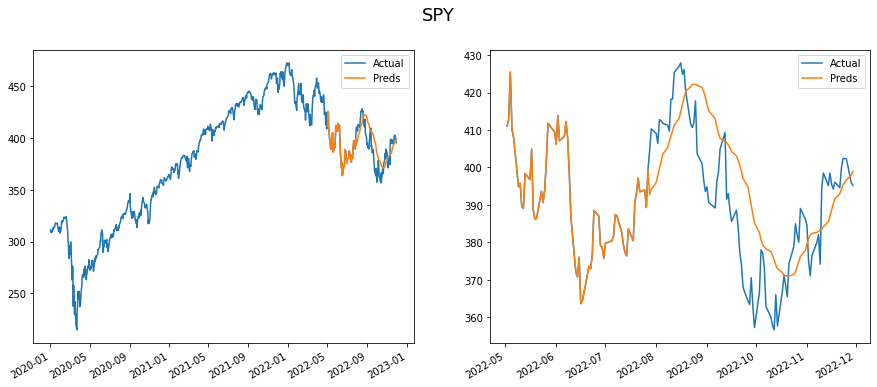

In [6]:
# args: ticker | kwargs: start='2020-01-01', end=today, units=32
modeling('SPY')

[Grabbing data...]
Using 2013 days for training, 503 days for validating.

Creating training data...
-    Before reshape: (1953, 60), (1953,)
-    After reshape: (1953, 60, 1), (1953,)
Created training data.

Creating validation data...
-    Before reshape: (443, 60), (443, 1)
-    After reshape: (443, 60, 1), (443,)
Created validation data.

Created and compiled LSTM model.

Training model...
Epoch 1/10
123/123 [==============================] - 7s 39ms/step - loss: 0.0011 - MSE: 0.0011
Epoch 2/10
123/123 [==============================] - 6s 47ms/step - loss: 1.4659e-04 - MSE: 1.4659e-04
Epoch 3/10
123/123 [==============================] - 5s 40ms/step - loss: 1.2967e-04 - MSE: 1.2967e-04
Epoch 4/10
123/123 [==============================] - 4s 36ms/step - loss: 1.3538e-04 - MSE: 1.3538e-04
Epoch 5/10
123/123 [==============================] - 5s 44ms/step - loss: 1.2518e-04 - MSE: 1.2518e-04
Epoch 6/10
123/123 [==============================] - 5s 37ms/step - loss: 1.1393e-04 - MSE

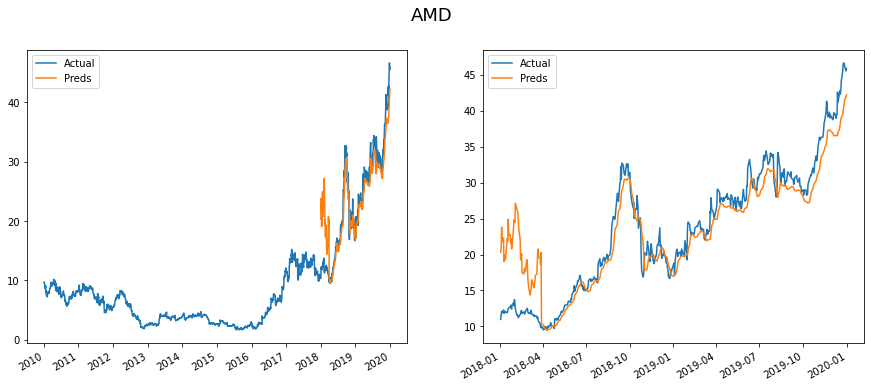

In [7]:
modeling('AMD', start='2010-01-01', end='2020-01-01')